In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
import cv2
import torch
import torch.nn as nn
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision
from torchvision import transforms
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import Dataset,DataLoader
import warnings
warnings.filterwarnings("ignore")

/kaggle/input/coic2/unlabel-flowers/45.jpg
/kaggle/input/coic2/unlabel-flowers/56.jpg
/kaggle/input/coic2/unlabel-flowers/89.jpg
/kaggle/input/coic2/unlabel-flowers/20.jpg
/kaggle/input/coic2/unlabel-flowers/58.jpg
/kaggle/input/coic2/unlabel-flowers/150.jpg
/kaggle/input/coic2/unlabel-flowers/6.jpg
/kaggle/input/coic2/unlabel-flowers/109.jpg
/kaggle/input/coic2/unlabel-flowers/149.jpg
/kaggle/input/coic2/unlabel-flowers/76.jpg
/kaggle/input/coic2/unlabel-flowers/71.jpg
/kaggle/input/coic2/unlabel-flowers/153.jpg
/kaggle/input/coic2/unlabel-flowers/143.jpg
/kaggle/input/coic2/unlabel-flowers/115.jpg
/kaggle/input/coic2/unlabel-flowers/131.jpg
/kaggle/input/coic2/unlabel-flowers/5.jpg
/kaggle/input/coic2/unlabel-flowers/151.jpg
/kaggle/input/coic2/unlabel-flowers/8.jpg
/kaggle/input/coic2/unlabel-flowers/84.jpg
/kaggle/input/coic2/unlabel-flowers/85.jpg
/kaggle/input/coic2/unlabel-flowers/67.jpg
/kaggle/input/coic2/unlabel-flowers/118.jpg
/kaggle/input/coic2/unlabel-flowers/82.jpg
/kagg

In [ ]:
path = os.path.join("/kaggle/input/coic2")
os.listdir(path)
path

In [7]:
train_path = os.path.join(path,'flowers')
#classes = {label: idx for idx, label in enumerate(os.listdir(os.path.join(train_path)))}
classes = {'daisy':0 ,'dandelion':1, 'rose':2,'sunflower':3,'tulip':4}
classes

{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}

In [8]:
def make_samples():
    images = []
    
    for class_name in sorted(classes.keys()):

        dir = os.path.join(train_path,class_name)
        
        for root, _, fnames in sorted(os.walk(dir,followlinks=True)):
            for fname in sorted(fnames):
                if '.jpg' in fname:
                    path = os.path.join(root,fname)
                    item = (path, classes[class_name])
                    images.append(item)
    images = pd.DataFrame(images).rename(columns={0:'fname',1:'label'})
    return images
samples = make_samples()

#### Check classes are balanced

It seems like balanced;)

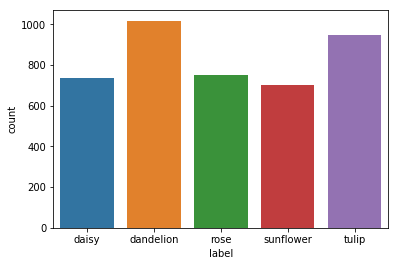

In [9]:
ax = sns.countplot(samples.label.map({idx:i for idx,i in enumerate(classes)}))

In [10]:
transform = transforms.Compose([
    transforms.RandomRotation(10,resample=False, expand=False, center=None),
    transforms.CenterCrop(224),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0, 0, 0), (1, 1, 1)),
])

In [11]:
class FlowerDataset(Dataset):
    
    def __init__(self,df,transforms = None):
        
        self.df = df
        self.img = self.df.fname.values
        if 'label' not in self.df.columns:
            self.label = None
        else:
            self.label = self.df.label.values
        self.transforms = transforms
        
    def __len__(self):
        
        return len(self.img)
    
    def __getitem__(self,idx):
        
        img = cv2.imread(self.img[idx])
        # Change BGR to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(224,224))
        if self.label is not None:
            target = self.label[idx]
            if self.transforms:
                img = Image.fromarray(img)
                img = self.transforms(img)
                #permute dimensions compatible with before augmentation and pytorch format
                return torch.tensor(img).permute(0,2,1),target
            else:
                # rearrange dimensions compatible with pytorch format
                return torch.tensor(img).permute(2,1,0),target
        else:
            return torch.tensor(img).permute(2,1,0)

#### Before Augmentation

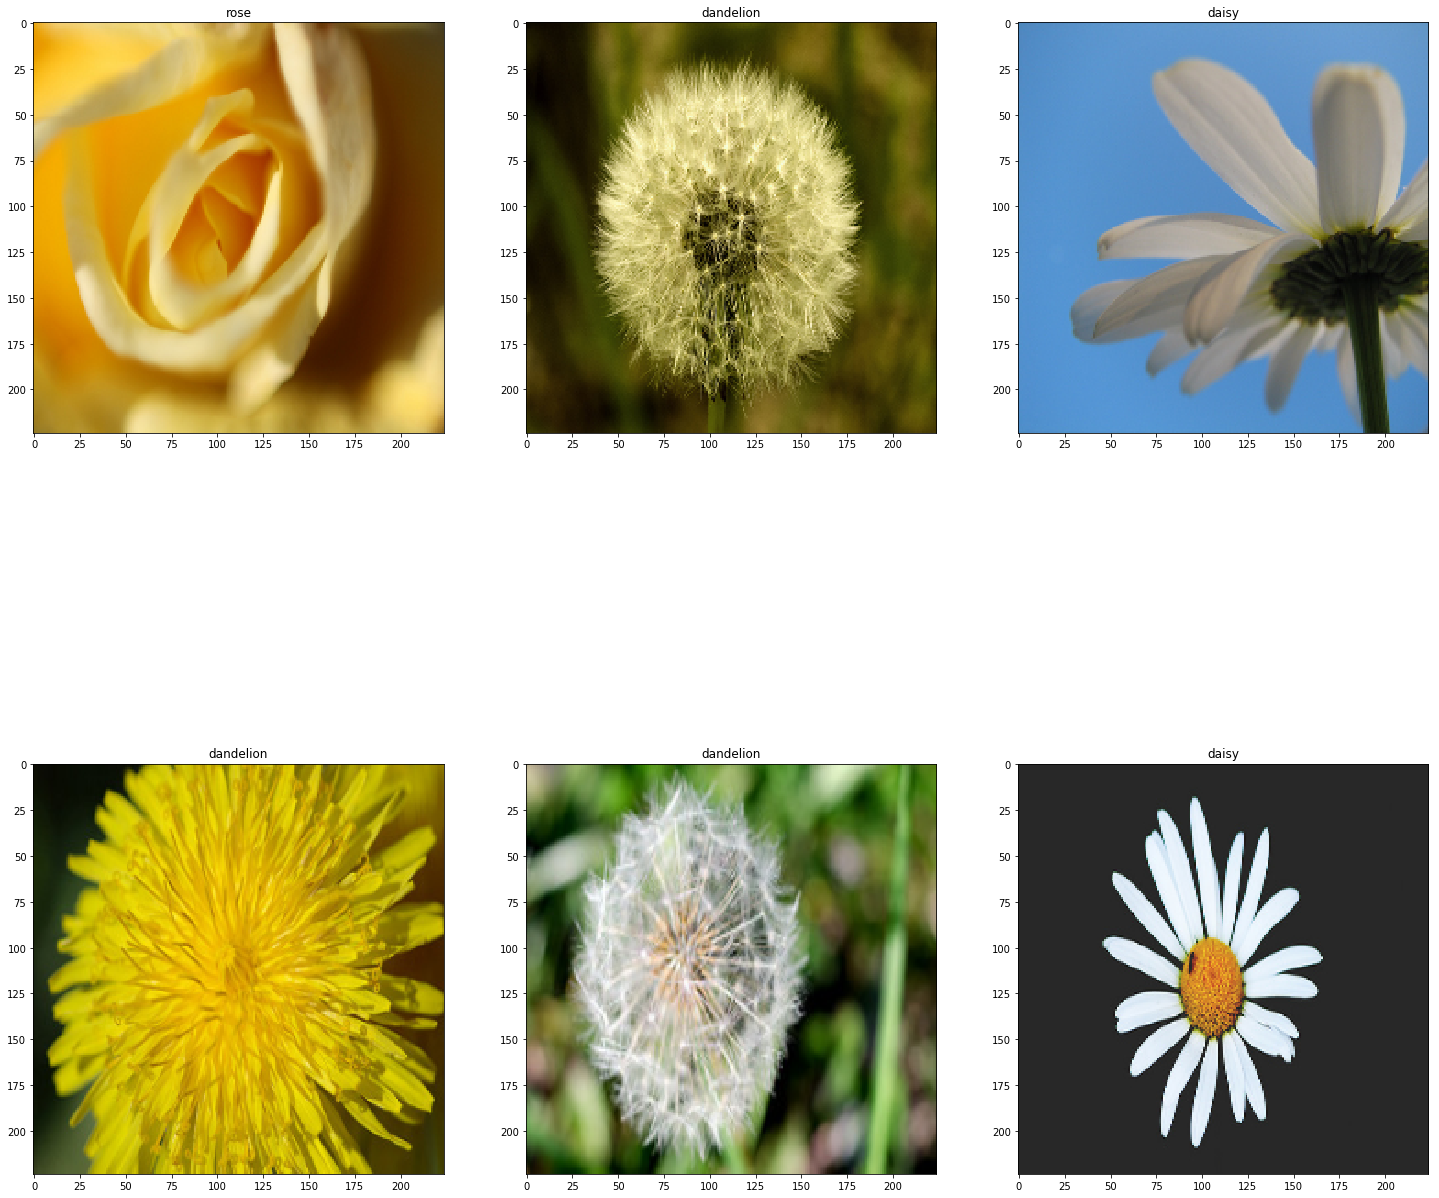

In [12]:
train_images = FlowerDataset(samples)
train_dataloader = torch.utils.data.DataLoader(train_images, batch_size=6, shuffle=True)
a = next(iter(train_dataloader))
fig,ax = plt.subplots(2,3, figsize=(25,25))
for i in range(6):
    j = i//3
    k = i%3
    ax[j,k].imshow(torch.transpose(a[0][i],0,2))
    ax[j,k].set_title(list(classes.keys())[a[1][i]])
plt.show()

#### After Augmentation

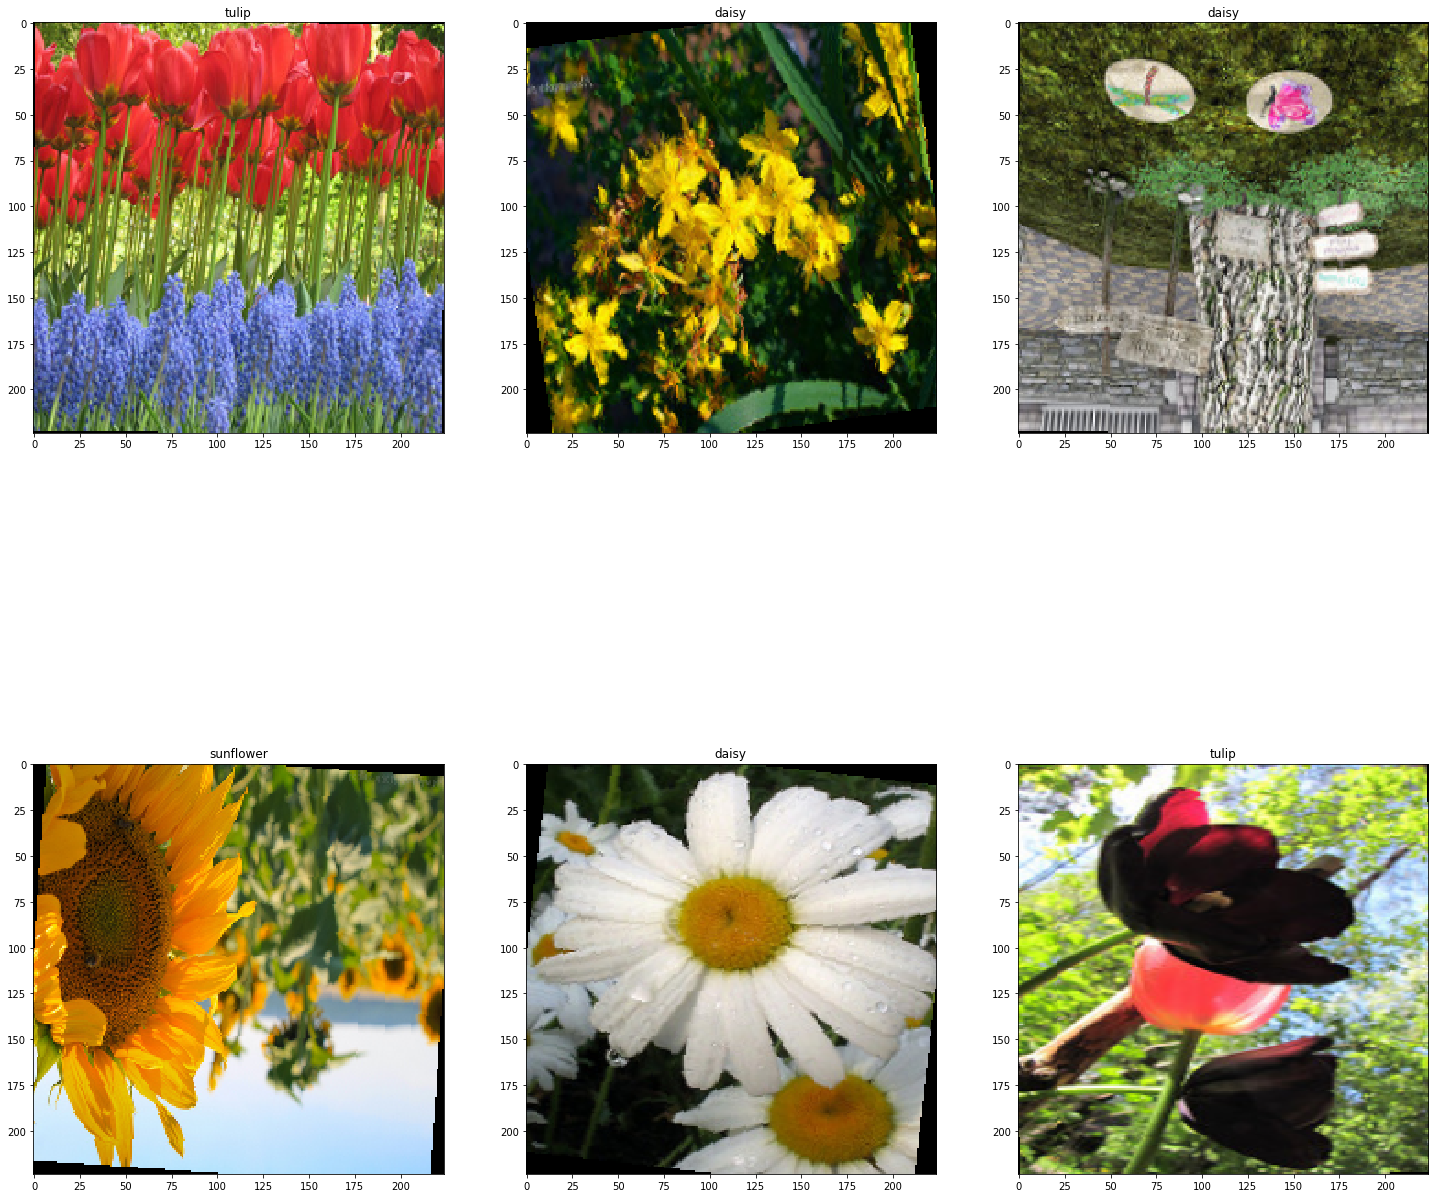

In [13]:
train_images = FlowerDataset(samples,transforms=transform)
train_dataloader = torch.utils.data.DataLoader(train_images, batch_size=6, shuffle=True)
a = next(iter(train_dataloader))
fig,ax = plt.subplots(2,3, figsize=(25,25))
for i in range(6):
    j = i//3
    k = i%3
    ax[j,k].imshow(torch.transpose(a[0][i],0,2))
    ax[j,k].set_title(list(classes.keys())[a[1][i]])
plt.show()

Flowers look beautiful! ;-)

### Build NN Model(With pretrained resnet152)

In [14]:
from torchvision import transforms, models

In [15]:
class FlowerNet(nn.Module):
    def __init__(self):
        super(FlowerNet, self).__init__()
        self.resnet = models.resnet152(pretrained=True, progress=False)
        self.fc1 = nn.Linear(1000,500)
        self.fc2 = nn.Linear(500,128)
        self.fc3 = nn.Linear(128, 5)
        for param in self.resnet.parameters():
            param.requires_grad = False
    def forward(self,x):
        x = self.resnet(x)
        # Adding classifier layers
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = FlowerNet().to(device)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth


#### I found useful package which is convinient to see the summary of structure ;-)

In [17]:
!pip install torchsummary
from torchsummary import summary

#### Since resnet152 is needed (224,224) input size, you need to resize it.(as I modified the size in the dataset(FlowerDataset) class)

In [18]:
summary(model,(3,224,224)) #input = (Channel,Height,Width)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [19]:
train_losses = []
train_accs = []
val_losses = []
val_accs = []
def Train(model):
    model.train()
    epochs=10
    for epoch in range(epochs):
        print('epochs : {}/{}'.format(epoch+1,epochs))
        running_loss = 0.
        running_acc = 0.
        for idx, (inputs,labels) in tqdm(enumerate(train_loader),total=len(train_loader)):
            optimizer.zero_grad()
            inputs = inputs.to(device)
            labels = labels.to(device)
            preds = model(inputs.float())
            loss_val = loss(preds, labels)
            pred_classes = preds.argmax(dim=1)
            loss_val.backward()
            optimizer.step()
            running_loss += loss_val
            running_acc += (pred_classes == labels.data).float().mean()
        
        train_loss = running_loss/len(train_loader)
        train_acc = running_acc/len(train_loader)
        print('train_loss : {:.4f}, train_acc : {:.2f}%'.format(train_loss,train_acc))
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        Valid(model)
    return model
def Valid(model):
    #model.eval()
    running_loss = 0.
    running_acc = 0.
    with torch.no_grad():
        
        for idx, (inputs,labels) in enumerate(valid_loader):
            
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            preds = model(inputs.float())
            loss_val = loss(preds,labels)
            pred_classes = preds.argmax(dim=1)
            
            running_loss += loss_val
            running_acc += (pred_classes == labels.data).float().mean()
            
        val_loss = running_loss/len(valid_loader)
        val_acc = running_acc/len(valid_loader)
        print('val_loss : {:.2f}, val_acc : {:.2f}%'.format(val_loss,val_acc))
        val_losses.append(val_loss)
        val_accs.append(val_acc)
def Test(model):
    prediction = []
    test_images = FlowerDataset(pd.DataFrame(test_samples))
    test_loader = torch.utils.data.DataLoader(test_images, batch_size=32, shuffle=False)
    model.eval()

    for idx, (inputs) in enumerate(test_loader):
            inputs = inputs.to(device)
            preds = model(inputs.float())
            pred_classes = preds.argmax(dim=1)
            prediction.append(pred_classes.cpu().detach().numpy())
    prediction = np.hstack(prediction)
    return prediction
            

#### Train and Valid Split (Stratified way 8:2) ver.1

#### Stratified KFOLD (5 Fold) ver.2

#### Train and Valid Split (Stratified way 95:5) ver.3

#### Stratified KFOLD (10 Fold) ver.4

In [20]:
'''
from sklearn.model_selection import train_test_split
train_set, valid_set, _, _ = train_test_split(samples, samples.label,
                                                    stratify=samples.label, 
                                                    test_size=0.05)
'''

'\nfrom sklearn.model_selection import train_test_split\ntrain_set, valid_set, _, _ = train_test_split(samples, samples.label,\n                                                    stratify=samples.label, \n                                                    test_size=0.05)\n'

In [21]:
def make_test_samples():
    images = []
    
    path = '/kaggle/input/coic2'
    dir = os.path.join(path,'unlabel-flowers')
        
    for root, _, fnames in os.walk(dir,followlinks=True):
        for fname in fnames:
            if '.jpg' in fname:
                path = os.path.join(root,fname)
                item = (path)
                images.append(item)
    images = pd.DataFrame(images).rename(columns= {0:'fname'})
    return images
test_samples = make_test_samples()

In [22]:
from sklearn.model_selection import StratifiedKFold
folds  = 10
skf = StratifiedKFold(n_splits=folds, random_state=7, shuffle=True)

In [23]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)

In [ ]:
for idx, (train_idx,valid_idx) in enumerate(skf.split(samples,samples.label)):
    train_images = FlowerDataset(samples.iloc[train_idx],transforms=transform)
    train_loader = torch.utils.data.DataLoader(train_images, batch_size=32, shuffle=True)
    valid_images = FlowerDataset(samples.iloc[valid_idx])
    valid_loader = torch.utils.data.DataLoader(valid_images, batch_size=32, shuffle=True)
    model = Train(model)
prediction = Test(model)

epochs : 1/10


In [ ]:
prediction = Test(model)

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15, 5))
axs[0,0].plot(train_accs)
axs[0,0].set_title('Train Accuracy')
axs[0,1].plot(train_losses)
axs[0,1].set_title('Train Loss')
axs[1,0].plot(val_accs)
axs[1,0].set_title('Val Accuracy')
axs[1,1].plot(val_losses)
axs[1,1].set_title('Val Loss')
fig.tight_layout()

### Evaluation

### This is prediction Result ;-)

In [ ]:
test_samples['label'] = prediction
test_images = FlowerDataset(test_samples)
test_loader = torch.utils.data.DataLoader(test_images, batch_size=15, shuffle=True)

In [ ]:
a = next(iter(test_loader))
fig,ax = plt.subplots(5,3, figsize=(25,25))
for i in range(15):
    j = i//3
    k = i%3
    ax[j,k].imshow(torch.transpose(a[0][i],0,2))
    ax[j,k].set_title(list(classes.keys())[a[1][i]])
plt.show()

#### It is unclear how to format the submission file ;-), so this is arbitrary one.

In [ ]:
submission = pd.DataFrame(test_samples.fname.str.split('/').str.get(-1))

In [ ]:
#decode = {'daisy':1 ,'dandelion':2, 'rose':3,'sunflower':4,'tulip':5}
#decode = {'daisy':1 ,'dandelion':2, 'rose':3,'sunflower':4,'tulip':5}
decode = {0:1,1:2,2:3,3:4,4:5}
submission['label'] = prediction
submission.label = submission.label.map(decode)

In [ ]:
submission

In [ ]:
submission.to_csv('submission.csv',index=False)